# Assignment 2 - DS4Biz Y63
## TextScraping_Classification
***

### Team Detail
**Team Name**: sompinandsomshine   
***
### *Student 1*
**Student ID**: 61070278   
**Student Full Name**: นายกิตติภณ สุรุ่งเรืองสกุล
***
### *Student 2*
**Student ID**: 61070330   
**Student Full Name**: นางสาวอิงฟ้า ภูติวรนาถ
***

<b>import package ที่ต้องใช้</b>

- requests, bs4 ใช้ scrape ข้อมูลจากหน้าเว็บ
- pandas(pd), numpy(np) ใช้จัดการข้อมูลที่ scrape มาเช่น ทำเป็น DataFrame, แปลงเป็น csv/txt
- warnings ใช้ปิด warning ที่แจ้งเตือน
- CountVectorizer, TfidfTransformer, TfidfVectorizer ใช้เตรียมข้อมูลเช่น ทำ term weighting
- MultiLabelBinarizer
- nltk ใช้ในการประมวลผลภาษาธรรมชาติเช่น กำจัด stopwords (คำที่เกิดขึ้นบ่อยและไม่มีอิทธิพลในการจำแนก)
- train_test_split, cross_val_score, StratifiedKFold, GridSearchCV นำมาทำ model selection และหา best hyperparameter
- neighbors(KNeighborsClassifier), linear_model(LogisticRegression), ensemble(RandomForestClassifier) model ที่จะนำมาใช้ในการทำนายว่าแต่Tagsเป็นประเภทไหน

In [36]:
import requests
import bs4

import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection

#### link: https://quotes.toscrape.com/

ใช้ **requests.get** ตรวจสอบว่าลิงก์ที่ต้องการ scrape ข้อมูลสามารถเข้าได้มั้ย

In [37]:
response = requests.get('https://quotes.toscrape.com/page/1/')
print(response) # response 200 คือสามารถเข้าถึงได้ พร้อมดึงข้อมูลprint(type(response))
html_page = bs4.BeautifulSoup(response.content, 'html.parser')
# print(html_page)

<Response [200]>
<class 'requests.models.Response'>


website ที่ต้องการดึงข้อมูลนั้นไม่มีบอกจำนวนหน้าชัดเจนเลยทำการเช็คดูก่อนว่ามีทั้งหมดกี่หน้า โดยจะใช้ while loop วนเช็คไปเรื่อยๆ เมื่อเจอข้อความว่า **No quotes found!** ก็จะทำการหยุด loop แต่ถ้าไม่พบข้อความดังกล่าวก็จะทำการเพิ่มเลขหน้านั้นไปที่ list ที่ชื่อว่า list_page

In [38]:
list_page = [] #เก็บ url หน้าทั้งหมด
cur = 1 #ให้เริ่มหาตั้งแต่หน้าที่ 1
while 1: #ทำการวนลูปไปเรื่อยๆ แล้วค่อยไปหยุดตามเงื่อนไขข้างใน loop
    url = 'https://quotes.toscrape.com/page/'+str(cur)+'/' #เอา cur มาประกอบกันเป็นลิงก์
    response = requests.get(url)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')
    selector = 'body > div > div:nth-child(2) > div.col-md-8'
    tag = html_page.select_one(selector)
    #เช็คว่าเจอข้อความ error มั้ย
    if 'No quotes found!' in tag.text:
        break
    #ถ้าไม่เจอก็จะทำการเพิ่มหน้าไปที่ list_page
    else:
        list_page.append(url)
        cur += 1


In [39]:
list_page

['https://quotes.toscrape.com/page/1/',
 'https://quotes.toscrape.com/page/2/',
 'https://quotes.toscrape.com/page/3/',
 'https://quotes.toscrape.com/page/4/',
 'https://quotes.toscrape.com/page/5/',
 'https://quotes.toscrape.com/page/6/',
 'https://quotes.toscrape.com/page/7/',
 'https://quotes.toscrape.com/page/8/',
 'https://quotes.toscrape.com/page/9/',
 'https://quotes.toscrape.com/page/10/']

In [40]:
#สร้าง DataFrame เพื่อรอเก็บข้อมูลที่ดึงได้
df = pd.DataFrame(columns=['content','author','tags', 'link_author'])
df

,content,author,tags,link_author


สร้าง Function ที่ใช้ดึงข้อมูลในส่วนต่างๆได้แก่ content, author, tags, link_author

โดยจะมี Function **extract_quotes** เพื่อเรียกใช้งาน Function ทั้งหมดอีกรอบนึง

In [41]:
# Content ดึงในส่วนของข้อความ
def extract_content(html_page):
    selector = 'div.col-md-8 > div > span.text'
    tags = html_page.select(selector)
    content = []
    
    for tag in tags:
        content.append(tag.text.strip().replace('“', '').replace('”', ''))
        
    return content

In [42]:
# Author ดึงในส่วนของชื่อผู้เขียน
def extract_author(html_page):
    selector = 'div.col-md-8 > div > span > small'
    tags = html_page.select(selector)
    author = []
    
    for tag in tags:
        author.append(tag.text.strip().replace('-', ' '))
        
    return author

In [43]:
# tags ดึงในส่วนของ tags ของข้อความ
def extract_tags(html_page):
    selector = 'div.col-md-8 > div > div > meta'
    tags = html_page.select(selector)
    quote_tags = []
    
    for tag in tags:
#         print(tag['content'])
        quote_tags.append(tag['content'])
        
    return quote_tags

In [44]:
# link_author ดึงในส่วนของลิงก์ประวัติผู้เขียน
def extract_link_author(html_page):
    selector = 'div.col-md-8 > div > span > a'
    tags = html_page.select(selector)
    link_author = []
    
    for tag in tags:
#         print(tag['content'])
        link_author.append('https://quotes.toscrape.com/author/' + tag['href'].split('/')[-1] + '/')
        
    return link_author

In [46]:
#เรียกใช้งาน Function ทั้งหมดร่วมกัน
def extract_quotes(url):
    response = requests.get(url)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')

#     เอาข้อมูลที่ดึงได้มาเก็บไว้ที่ตัวแปรแต่ละตัว
    content = extract_content(html_page)
    author = extract_author(html_page)
    tags = extract_tags(html_page)
    link_author = extract_link_author(html_page)
    
#     เอาข้อมูลที่เก็บไว้ในตัวแปรไปสร้างเป็น DataFrame
    Alltags = {'content':content,'author':author,'tags':tags,'link_author':link_author}
    result = pd.DataFrame(Alltags)
    return result #คืนค่า DataFrame กลับไป

ทำ For loop เพื่อดึงข้อมูลในแต่ละหน้าใน **list_page** โดยข้อมูลที่ดึงได้จะถูกเพิ่มไปใน df ที่สร้างไว้ก่อนหน้า

In [47]:
for url in list_page:
    result = extract_quotes(url)
    df = df.append(result, ignore_index=True)
df.head()

,content,author,tags,link_author
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...


## scrape author detail

ดึงข้อมูลส่วนตัวของผู้เขียน

In [51]:
# author born date ข้อมูลวันเกิด
def born_date(html_page):
    born_date = html_page.findAll("span", {"class": "author-born-date"})
    born_date = born_date[0].text.replace(',', '').replace(' ', '-')
    return born_date

In [52]:
# author born location ข้อมูลสถานที่เกิด
def born_location(html_page):
    born_location = html_page.findAll("span", {"class": "author-born-location"})
    born_location = born_location[0].text.replace(',', '|')
    return born_location

In [53]:
# author Description คำบรรยาย
def description(html_page):
    description = html_page.findAll("div", {"class": "author-description"})
    description = description[0].text.strip()
    return description

In [54]:
# author author name ข้อมูลชื่อผู้เขียน
def author_name(html_page):
    author_name = html_page.findAll("h3", {"class": "author-title"})
    author_name = author_name[0].text.strip().replace('-', ' ')
    return author_name

ทำการดึงข้อมูลส่วนตัวของผู้เขียนแล้วเก็บไว้ใน list ต่างๆ

In [56]:
# สร้าง list เพื่อรอเก็บข้อมูลที่ดึงได้
list_born_date = []
list_born_location = []
list_description = []
list_author_name = []

for link_author in list(df['link_author'].unique()):
    
#     response = requests.get('https://quotes.toscrape.com/author/Albert-Einstein/')
    response = requests.get(link_author)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')
    
#     เพิ่มข้อมูลที่ดึงได้ไปใส่ไว้ใน list
    list_born_date.append(born_date(html_page))
    list_born_location.append(born_location(html_page))
    list_description.append(description(html_page))
    list_author_name.append(author_name(html_page))

เอา list ที่เก็บข้อมูลส่วนตัวผู้เขียนมาสร้างเป็น DataFrame

In [57]:
Alldetail = {'author': list_author_name, 'born_date': list_born_date, 'born_location': list_born_location, 'author_description':list_description}
author_df = pd.DataFrame(Alldetail)

In [58]:
# ตัวอย่าข้อมูลส่วนตัวผู้เขียน
author_df.head()

,author,born_date,born_location,author_description
0,Albert Einstein,March-14-1879,in Ulm| Germany,"In 1879, Albert Einstein was born in Ulm, Germ..."
1,J.K. Rowling,July-31-1965,in Yate| South Gloucestershire| England| The U...,See also: Robert GalbraithAlthough she writes ...
2,Jane Austen,December-16-1775,in Steventon Rectory| Hampshire| The United Ki...,Jane Austen was an English novelist whose work...
3,Marilyn Monroe,June-01-1926,in The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...
4,André Gide,November-22-1869,in Paris| France,André Paul Guillaume Gide was a French author ...


In [59]:
# ตัวอย่างข้อมูลที่ดึงไว้ในตอนแรก
df.head()

,content,author,tags,link_author
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...


จะทำการเอา 2 DataFrame มา join กัน เพื่อเพิ่มข้อมูลส่วนตัวผู้เขียนเข้าไปไว้ใน DataFrame ที่ดึงไว้ตอนแรก

In [60]:
# ทำการ join ข้อมูลทั้ง 2 DataFrame แล้วเก็บในตัวแปร content_author_df
content_author_df = pd.merge(df, author_df, on='author', how='left')
content_author_df.head()

,content,author,tags,link_author,born_date,born_location,author_description
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...,March-14-1879,in Ulm| Germany,"In 1879, Albert Einstein was born in Ulm, Germ..."
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/,July-31-1965,in Yate| South Gloucestershire| England| The U...,See also: Robert GalbraithAlthough she writes ...
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...,March-14-1879,in Ulm| Germany,"In 1879, Albert Einstein was born in Ulm, Germ..."
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/,December-16-1775,in Steventon Rectory| Hampshire| The United Ki...,Jane Austen was an English novelist whose work...
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...,June-01-1926,in The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...


## Clean missing Values

In [61]:
df.to_csv('datastore/content.csv', index=False)

In [62]:
df = pd.read_csv('datastore/content.csv')
df.head()

,content,author,tags,link_author
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...


ทำการเช็คข้อมูลดูว่ามีค่า null มั้ย

In [63]:
df.isna().sum() # เช็คค่า null

content        0
author         0
tags           3
link_author    0
dtype: int64

พบค่า null 3 ตัวที่ column tags เลยลองค้นหาดูว่าหน้าตาเป็นยังไง

In [64]:
df[df['tags'].isna()]

,content,author,tags,link_author
27,It is impossible to live without failing at so...,J.K. Rowling,NaN,https://quotes.toscrape.com/author/J-K-Rowling/
42,You believe lies so you eventually learn to tr...,Marilyn Monroe,NaN,https://quotes.toscrape.com/author/Marilyn-Mon...
78,The question isn't who is going to let me; it'...,Ayn Rand,NaN,https://quotes.toscrape.com/author/Ayn-Rand/


ทำการลบข้อมูล 3 ตัวนั้นทิ้ง

In [65]:
df = df.dropna(subset=['tags']) # ลบค่า null

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   content      97 non-null     object
 1   author       97 non-null     object
 2   tags         97 non-null     object
 3   link_author  97 non-null     object
dtypes: object(4)
memory usage: 3.8+ KB


## Change Tags(target) to Multi-Label Classification

In [67]:
tags_new = [] # 
for i in df['tags']:
    tags_new.append(i.split(',')) #for each tags cell, create a list of items from the original string, using a comma as a delimeter

# เพิ่ม tags_new ไปใน dataframe
df['tags_new'] = tags_new 

## MultiLabelBinarizer takes an iterable list and turns it into columns with binary values that represent the list.
## For example, [love, books] -> love and books columns with a value of 1, all other columns with a value of 0

#initialize MultiLabelBinarizer 
mlb = MultiLabelBinarizer() 

#transform the tags_new column to a series of columns with binary values
binary_labels = pd.DataFrame(mlb.fit_transform(df['tags_new']),columns=mlb.classes_) 


#sort columns ตามตัวอักษร a-z
binary_labels = binary_labels.sort_index(axis=1) 

binary_labels

,abilities,activism,adulthood,adventure,age,alcohol,aliteracy,apathy,attributed,attributed-no-source,...,unhappy-marriage,value,wander,wisdom,women,world,write,writers,writing,yourself
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
tags_dict = {}
# รัน for loop เพื่อเก็บ tags และจำนวนที่เจอ ไว้ใน dict
for column in binary_labels:
    sum_num = binary_labels[column].sum(axis=0)
    tags_dict.update({column : sum_num})
    
# sort -> tags_dict
sort_tags_dict = {k: v for k, v in sorted(tags_dict.items(), key=lambda item: item[1], reverse = True)};

In [69]:
# tags ที่มีเยอะสุด 15 tags แรก
top15_tags = list(sort_tags_dict)[:15]
top15_tags

['love',
 'inspirational',
 'life',
 'humor',
 'books',
 'reading',
 'friendship',
 'friends',
 'truth',
 'attributed-no-source',
 'death',
 'simile',
 'writing',
 'children',
 'classic']

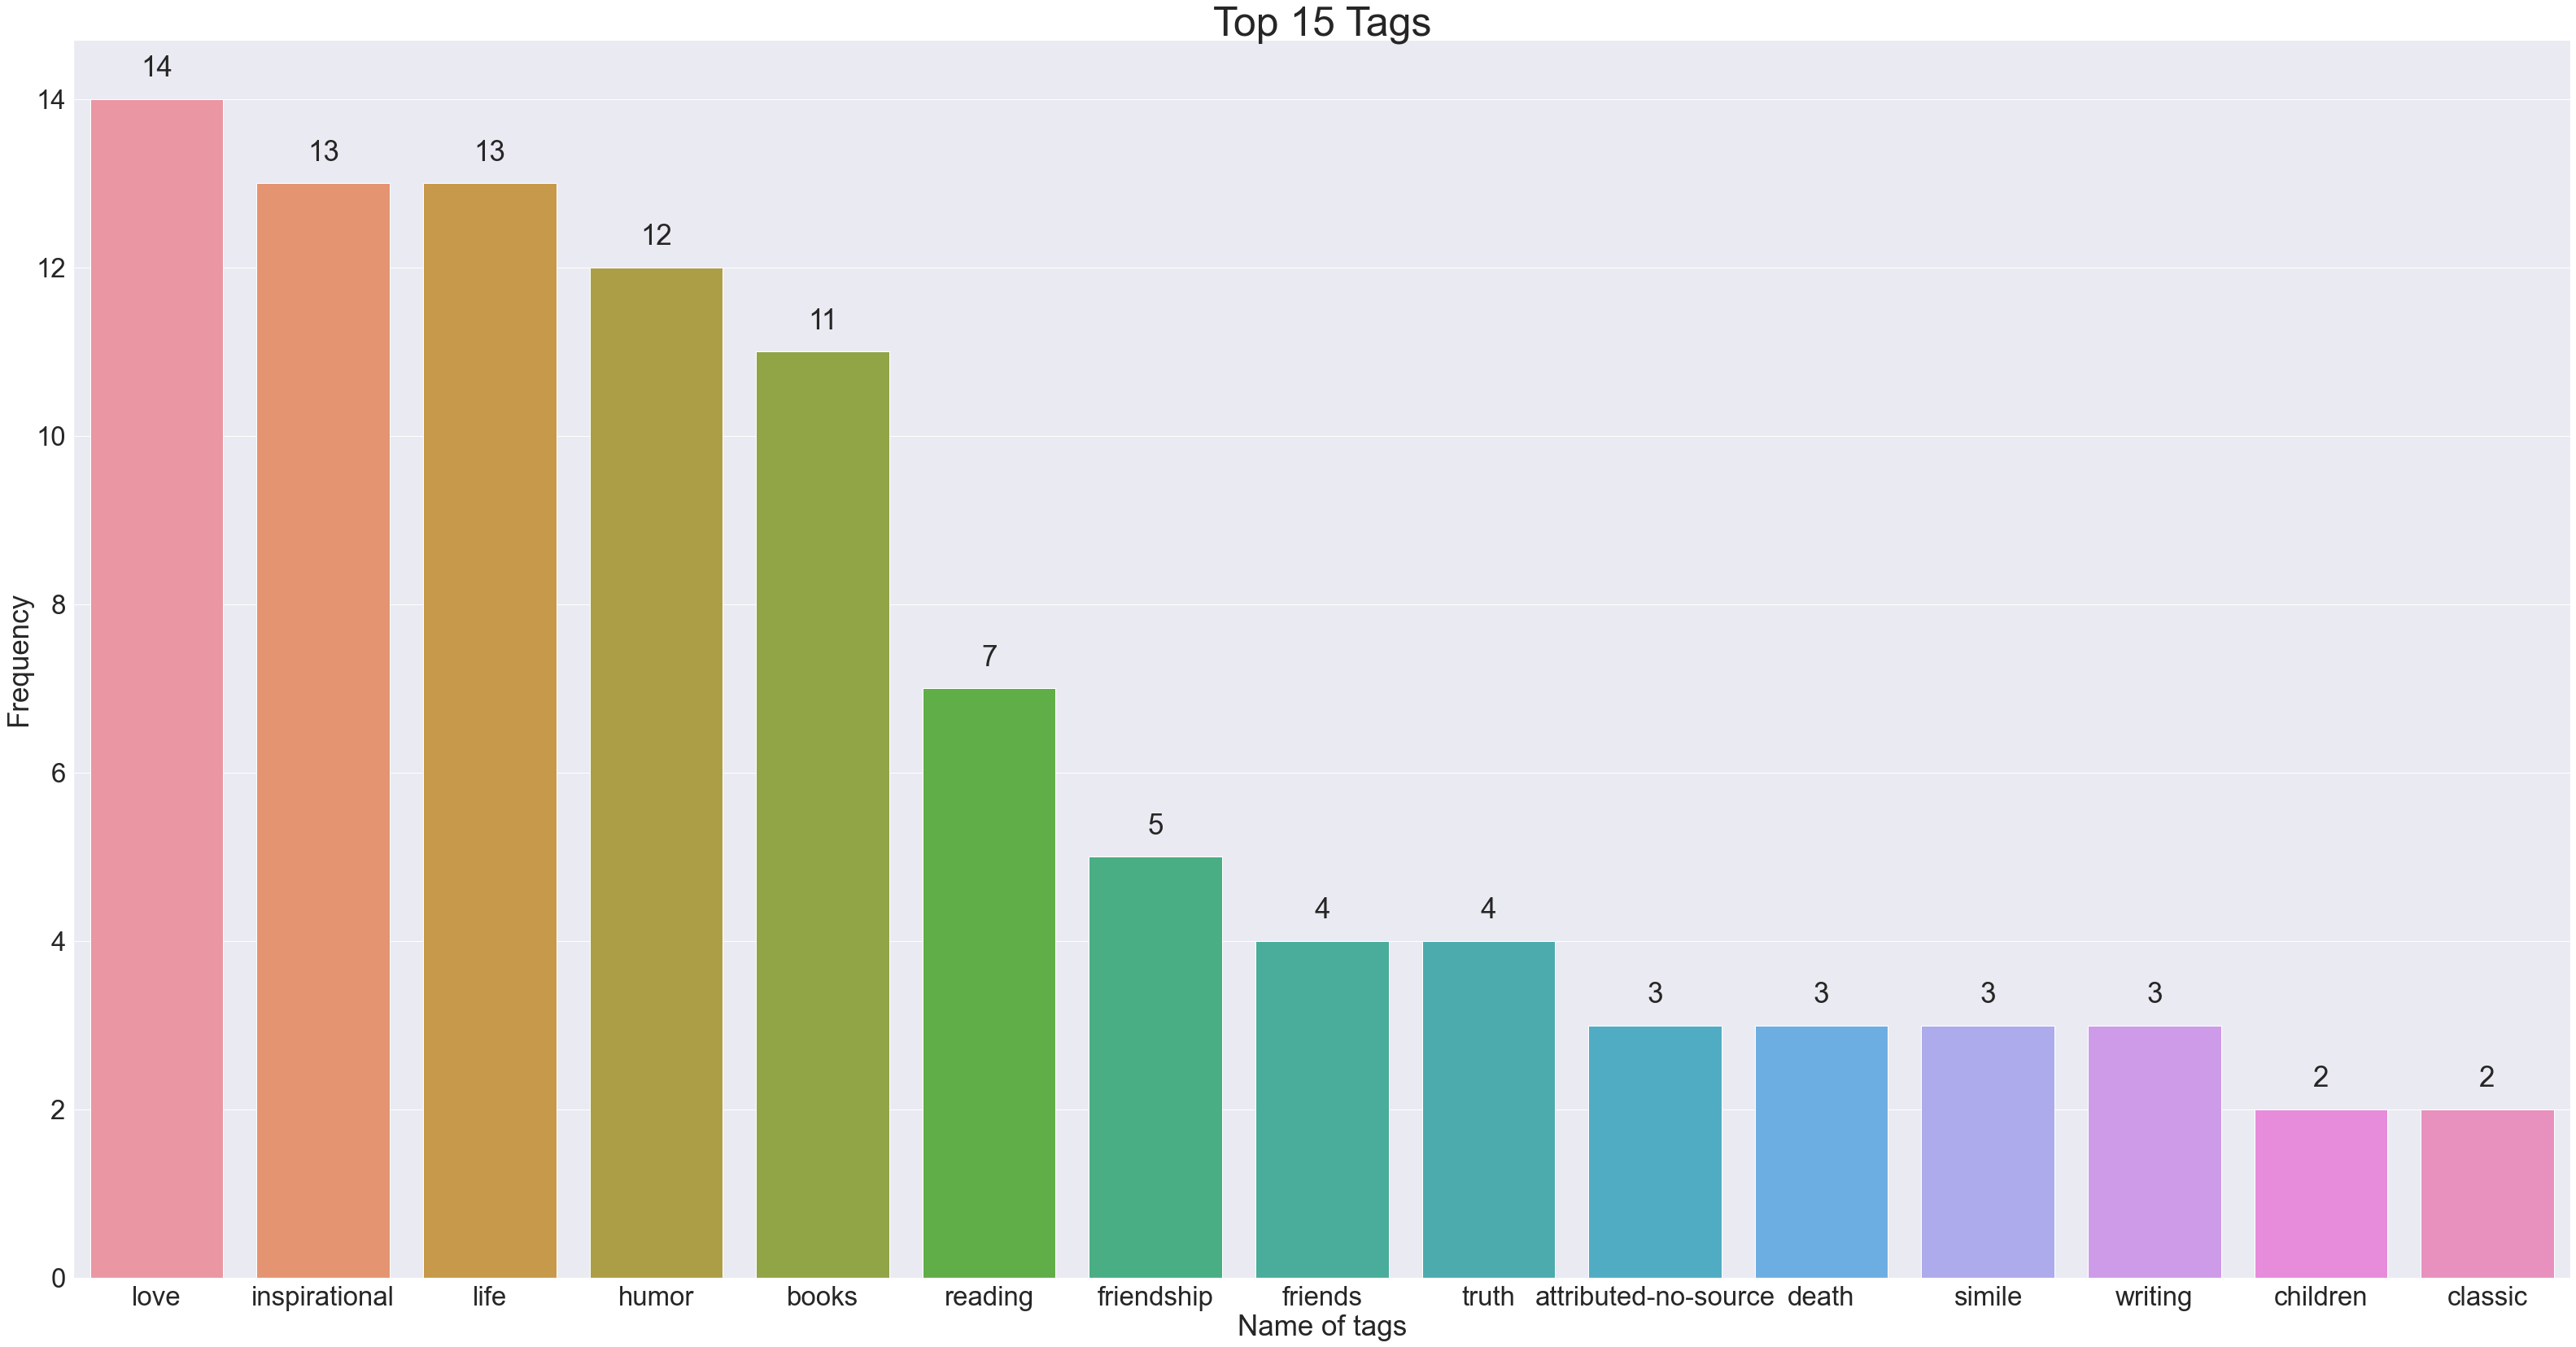

In [70]:
x = top15_tags # แกน x
y = [] # แกน y
for i in top15_tags:
    y.append(sort_tags_dict[i])  # วน for เพื่อเก็บค่า y จาก dict ให้อยู่ใน list

sns.set(font_scale = 3) # ขนาดตัวอักษร
plt.figure(figsize=(55,28)) # ขนาดของกราฟ
ax = sns.barplot(x, y) # plot
plt.title("Top 15 Tags", fontsize=50)  # ชื่อกราฟ
plt.ylabel('Frequency', fontsize=35)   # ชื่อแกน x
plt.xlabel('Name of tags', fontsize=35) # ชื่อแกน y

# เพิ่มตัวเลขในแต่ละกราฟแท่ง
rects = ax.patches
labels = y
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+1/5, label, ha='center', va='bottom', fontsize=35)
plt.show()

In [71]:
#นำ binary_labels มาต่อกับ df
df = df.merge(binary_labels, how='inner', left_index=True, right_index=True)
df.head()

,content,author,tags,link_author,tags_new,abilities,activism,adulthood,adventure,age,...,unhappy-marriage,value,wander,wisdom,women,world,write,writers,writing,yourself
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...,"[change, deep-thoughts, thinking, world]",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/,"[abilities, choices]",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...,"[inspirational, life, live, miracle, miracles]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/,"[aliteracy, books, classic, humor]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...,"[be-yourself, inspirational]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# select column -> content,tags,top15_tags
df = df[["content", "tags"] + top15_tags]
df.head()

,content,tags,love,inspirational,life,humor,books,reading,friendship,friends,truth,attributed-no-source,death,simile,writing,children,classic
0,The world as we have created it is a process o...,"change,deep-thoughts,thinking,world",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"It is our choices, Harry, that show what we tr...","abilities,choices",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,There are only two ways to live your life. One...,"inspirational,life,live,miracle,miracles",0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,"The person, be it gentleman or lady, who has n...","aliteracy,books,classic,humor",0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
4,"Imperfection is beauty, madness is genius and ...","be-yourself,inspirational",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## save DataFarame to csv/txt

- AllArticles_OnlyContent
- tags

In [38]:
AllArticles_OnlyContent = df['content']
tags = binary_labels

**csv**<br>
save เป็นไฟล์ประเภท csv

In [39]:
AllArticles_OnlyContent.to_csv('datastore/AllArticles_OnlyContent.csv', index=False)

In [40]:
tags.to_csv('target/tags.csv', index=False)

**txt**<br>
save เป็นไฟล์ประเภท txt

In [106]:
AllArticles_OnlyContent.to_csv(r'datastore/AllArticles_OnlyContent.txt', header=None, index=None, sep=' ', mode='a')

In [42]:
tags.to_csv(r'target/tags.txt', header=None, index=None, sep=' ', mode='a')

# Modeling

ทำการ Tunning hyperparameter และหา Model ที่ดีที่สุดในการทำนาย

- K-Nearest Neighbors
- Logistic Regression
- Random forest

## Having an Imbalanced Dataset?

In [43]:
sum_0, sum_1 = 0, 0

# วน for นับค่า 0,1
for i in top15_tags:
    sum_0 += df[i].value_counts()[0]
    sum_1 += df[i].value_counts()[1]

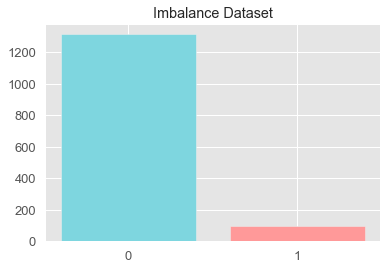

In [45]:
plt.style.use('ggplot')
labels = ['0', '1']  # แกน x
sizes = [sum_0, sum_1] # ค่าแกน y

color=['#7ed6df','#ff9999']  #สี
labels_pos = np.arange(len(labels))  
plt.bar(labels_pos, sizes, color=color) # plot

matplotlib.rc('xtick', labelsize=10) # ขนาดตัวอักษรแกน x
matplotlib.rc('ytick', labelsize=10) # ขนาดตัวอักษรแกน y
plt.title("Imbalance Dataset")  # ชื่อกราฟ
plt.xticks(labels_pos, labels)
plt.show()

<b>จากกราฟ ทำให้เห็นได้ว่าข้อมูลมีค่า 0 กับ 1 มีจำนวนห่างกันมาก ซึ่งหมายความข้อมูล imbalance -> จะใช้ Precision และ Recall เป็นตัววัดผล

## Text preprocessing

สร้าง function ที่ต้องใช้ในการทำ preprocessing

In [46]:
#Tokenizer and WordNet Lemmatizer with POS (part of speech)
def lemma_tokenizer_w_pos_tag(text):
    # define a nested function for converting POS tag for Lemmatizer
    def convert_tags(tag):
        #แปลง tag ที่เป็น vbd vbg vbz ให้เป็น v
        if tag == 'vbd' or tag == 'vbg' or tag == 'vbz':
            return 'v'
        else: #นอกเหนือจากเงื่อนไขช้างบนให้เป็น n
            return 'n'
    
    standard_tokenizer = CountVectorizer().build_tokenizer()  #สร้างตัวที่ใช้แยก text (string) ที่เข้ามาออกเป็น tokens
    tokens = standard_tokenizer(text) #แยก text (string) ที่เข้ามาออกเป็น tokens
    tokens_with_pos_tag = nltk.pos_tag(tokens) #ติด pos_tag ให้กับแต่ละ token

    lemmatizer = nltk.WordNetLemmatizer() #สร้างตัวที่ใช้แปลงรูปของคำให้อยู่รูปฟอร์มพื้นฐาน (รากคำ)
    lemma_tokens = [] #สร้าง list ชื่อ lemma_tokens เพื่อรอเก็บคำหลังจากแปลงด้วย pos_tag อันใหม่
    for token in tokens_with_pos_tag: #วน for loop ในตัวแปร tokens_with_pos_tag
        new_tag = convert_tags(token[1].lower())
        lemma_tokens.append(lemmatizer.lemmatize(token[0], new_tag))
    
    return lemma_tokens

ตัวอย่างเมื่อเอาคำเข้าไปใน function lemma_tokenizer_w_pos_tag()

In [47]:
df['content'][0]

'The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.'

In [48]:
lemma_tokenizer_w_pos_tag(df['content'][0])

['The',
 'world',
 'a',
 'we',
 'have',
 'created',
 'it',
 'be',
 'process',
 'of',
 'our',
 'think',
 'It',
 'cannot',
 'be',
 'changed',
 'without',
 'change',
 'our',
 'thinking']

---

In [49]:
#ใช้ TfidfVectorizer() แทน CountVectorizer() และ TfidfTransformer()
#default ของ analyzer คือ word, กำจัด stop_words
non_weight_trans = TfidfVectorizer(stop_words="english",min_df = 0,tokenizer=lemma_tokenizer_w_pos_tag)

In [50]:
#Term weighting ใน Scikit-learn เราสามารถสร้างที่ TF-IDF weighted document-term matrix โดยใช้ TfidfVectorizer() แทน CountVectorizer()
#default ของ analyzer คือ word, กำจัด stop_words
weight_trans = TfidfVectorizer(analyzer='word', ngram_range=(1,3),min_df = 0, 
                             stop_words = 'english', sublinear_tf=True, lowercase=True)

## Create Function

In [51]:
# ฟังก์ชั่นแบ่งชุดข้อมูล
def train_test_data(tags_name, weight):
    x = df['content']
    y = df[tags_name]
    
    if weight: # weight transform
        X = weight_trans.fit_transform(x)
    else: # non-weight transform
        X = non_weight_trans.fit_transform(x)
    
    # #แบ่งข้อมูลเป็น 2 ส่วน train 90% test 10% เพราะข้อมูลเรามีน้อย
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

    return X_train, X_test, y_train, y_test

In [52]:
# ฟังก์ชั่นสร้างโมเดล
def create_model(model, params, weight):
    accuracy_list = []
    precision_list = []
    recall_list = []

    for tags_name in top15_tags:
        # เรียกใช้ฟังก์ชั่น split -> train, test
        X_train, X_test, y_train, y_test = train_test_data(tags_name, weight)
        
        # GridSearchCV
        skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001) #ทำการกำหนดเครื่องมือ K-fold ว่าจะใช้ 5 folds โดย StratifiedKFold เป็นการแบ่งข้อมูลรูปแบบหนึ่ง
        #เอา Classifier, params ใส่ลงไปและ กำหนด cv ด้วย k-flod ที่เรากำหนดไว้ในตัวแปร skf
        grid = GridSearchCV(model, params, verbose = 3, cv=skf.split(X_train,y_train), n_jobs = -1)
        grid.fit(X_train, y_train); #เอา GridSearchCV มา fit กับ train set
        
        # กำหนด parameter ตามที่หาได้ -> best parameter
        best_params = grid.best_params_
        model.set_params(**best_params)
        
        # ทำการ fit model กับ parameter ที่ดีที่สุดที่วิเคราะห์มาได้
        model.fit(X_train, y_train)
        
        # เอา model ที่ใช้ parameter ที่ดีที่สุดมา test กับ test set ที่แบ่งไว้ตอนแรก
        model_pred = model.predict(X_test)

        # หา accuracy ด้วย cross_val_score -> LeaveOneOut ซึ่งเหมาะกับข้อมูลน้อยๆ
        cv = LeaveOneOut()
        scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs = -1)
        accuracy_list.append(mean(scores))
        print('%s -> Accuracy: %.3f (%.3f)' % (tags_name ,mean(scores), std(scores)))

        # หา precision
        precision = metrics.precision_score(y_test, model_pred, average='macro')
        precision_list.append(precision)
        print('Precision Score: %.3f' % precision)

        # หา recall
        recall = metrics.recall_score(y_test, model_pred, average='macro')
        recall_list.append(recall)
        print('recall Score: %.3f' % recall)
        
    return (accuracy_list, precision_list, recall_list)

In [53]:
# dict เก็บค่า Accuracy, Precision, Recall ของทุกโมเดล
evaluation_models = {'Model':['KNN_non_weight', 'Knn_weight','lg_non_weight', 'lg_weight', 'rf_non_weight', 'rf_weight'], 
                     'Accuracy':[], 'Precision':[], 'Recall':[]}

In [54]:
# ฟังก์ชั่นแสดงตารางเปรียบเทียบค่า Accuracy, Precision, Recall แต่ละ tags
def evaluation_table(accuacy, precision, recall):
    data = {'Tags': np.array(top15_tags), 'Accuracy': np.array(accuacy), 
            'Precision': np.array(precision), 'Recall': np.array(recall)}
    df = pd.DataFrame(data=data)
    # เรียงค่าจากมากไปน้อยตามค่า Precision
    df = df.sort_values(by=['Precision'], ascending=False).reset_index(drop=True)

    # เพิ่ม Row ที่เป็นค่าเฉลี่ยของ Accuracy, Precision, Recall
    df = df.append({'Tags' : 'Average' , 
                            'Accuracy' : (sum(accuacy)/15), 
                            'Precision' : (sum(precision)/15),
                            'Recall': (sum(recall)/15)} , ignore_index=True)

    # highlight ค่า Average เพื่อให้มองเห็นได้ชัดเจน
    color = (df['Tags'] == 'Average').map({True: 'background-color: yellow', False: ''})
    df = df.style.apply(lambda s: color)
    
    # เพิ่มค่า Accuracy, Precision, Recall เข้า Dict -> evaluation_models เพื่อเอาไว้ไปแสดงเปรียบเทียบตอนสรุปผล
    evaluation_models['Accuracy'].append(sum(accuacy)/15)
    evaluation_models['Precision'].append(sum(precision)/15)
    evaluation_models['Recall'].append(sum(recall)/15)
    
    return df

## K-Nearest Neighbors

### KNN Tunning parameter แบบไม่ weight

In [56]:
knn = KNeighborsClassifier() # สร้าง K-Nearest Neighbors classifier

#ทำการกำหนด parameter ที่จะเอาไปวิเคราะห์ โดยค่าที่กำหนดไว้คือ parameter ของ knn
params = { 
    'n_neighbors' : list(np.arange(1,50,2)), #ให้ทำการทดลองหา k ที่ดีที่สุดตั้ง 1-50 โดยขยับทีละ 2 เช่น 1, 3, 5, ...
    'weights' : ['uniform', 'distance'],  #weight function ที่ใช้ในการทำนาย
    'metric' : ['euclidean', 'manhattan'] #คิดระยะหางด้วยวิธีไหน
}

In [57]:
# เรียกใช้ฟังก์ชั่น create_model
accuracy_list, precision_list, recall_list = create_model(knn, params, False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 363 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.8s finished


love -> Accuracy: 0.857 (0.350)
Precision Score: 0.944
recall Score: 0.750
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


inspirational -> Accuracy: 0.845 (0.362)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


life -> Accuracy: 0.905 (0.294)
Precision Score: 0.333
recall Score: 0.429
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


humor -> Accuracy: 0.905 (0.294)
Precision Score: 0.350
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


books -> Accuracy: 0.893 (0.309)
Precision Score: 0.389
recall Score: 0.438
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


reading -> Accuracy: 0.905 (0.294)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


friendship -> Accuracy: 0.940 (0.237)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


friends -> Accuracy: 0.952 (0.213)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


truth -> Accuracy: 0.952 (0.213)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


attributed-no-source -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


death -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished


simile -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


writing -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


children -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


classic -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished


In [58]:
# เรียกใช้ฟังก์ชั่น evaluation_table เพื่อแสดงตารางเปรียบเทียบ
evaluation_table(accuracy_list, precision_list, recall_list)

,Tags,Accuracy,Precision,Recall
0,reading,0.904762,1.000000,1.000000
1,friendship,0.940476,1.000000,1.000000
2,friends,0.952381,1.000000,1.000000
3,truth,0.952381,1.000000,1.000000
4,attributed-no-source,0.976190,1.000000,1.000000
5,death,0.964286,1.000000,1.000000
6,simile,0.976190,1.000000,1.000000
7,writing,0.964286,1.000000,1.000000
8,children,0.976190,1.000000,1.000000
9,classic,0.964286,1.000000,1.000000


### KNN Tunning parameter แบบ weight

In [59]:
knn = KNeighborsClassifier() # สร้าง K-Nearest Neighbors classifier

#ทำการกำหนด parameter ที่จะเอาไปวิเคราะห์ โดยค่าที่กำหนดไว้คือ parameter ของ knn
params = { 
    'n_neighbors' : list(np.arange(1,50,2)),
    'weights' : ['uniform', 'distance'], 
    'metric' : ['euclidean', 'manhattan'] 
}

In [60]:
# เรียกใช้ฟังก์ชั่น create_model
accuracy_list,precision_list,recall_list = create_model(knn, params, True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


love -> Accuracy: 0.869 (0.337)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


inspirational -> Accuracy: 0.857 (0.350)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


life -> Accuracy: 0.845 (0.362)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


humor -> Accuracy: 0.881 (0.324)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


books -> Accuracy: 0.869 (0.337)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


reading -> Accuracy: 0.917 (0.276)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


friendship -> Accuracy: 0.940 (0.237)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


friends -> Accuracy: 0.952 (0.213)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


truth -> Accuracy: 0.964 (0.186)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


attributed-no-source -> Accuracy: 0.976 (0.152)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


death -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


simile -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


writing -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


children -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits
classic -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished


In [61]:
# เรียกใช้ฟังก์ชั่น evaluation_table เพื่อแสดงตารางเปรียบเทียบ
evaluation_table(accuracy_list, precision_list, recall_list)

,Tags,Accuracy,Precision,Recall
0,life,0.845238,1.000000,1.000000
1,reading,0.916667,1.000000,1.000000
2,friendship,0.940476,1.000000,1.000000
3,friends,0.952381,1.000000,1.000000
4,death,0.964286,1.000000,1.000000
5,simile,0.976190,1.000000,1.000000
6,writing,0.964286,1.000000,1.000000
7,children,0.976190,1.000000,1.000000
8,classic,0.964286,1.000000,1.000000
9,love,0.869048,0.450000,0.500000


---

## Logistic Regression

### Logistic Regression Tunning parameter แบบไม่ weight

In [65]:
lg= LogisticRegression()  # สร้าง Logistic Regression classifier

#ทำการกำหนด parameter ที่จะเอาไปวิเคราะห์ โดยค่าที่กำหนดไว้คือ parameter ของ Logistic Regression
params = {"C":np.logspace(-4, 4, 50), 
          "penalty":["l1","l2"]  # l1 lasso l2 ridge
         }

In [66]:
# เรียกใช้ฟังก์ชั่น create_model
accuracy_list,precision_list,recall_list = create_model(lg, params, False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


love -> Accuracy: 0.881 (0.324)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


inspirational -> Accuracy: 0.869 (0.337)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


life -> Accuracy: 0.869 (0.337)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


humor -> Accuracy: 0.881 (0.324)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


books -> Accuracy: 0.893 (0.309)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


reading -> Accuracy: 0.917 (0.276)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


friendship -> Accuracy: 0.952 (0.213)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


friends -> Accuracy: 0.952 (0.213)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


truth -> Accuracy: 0.952 (0.213)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


attributed-no-source -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


death -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


simile -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


writing -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


children -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


classic -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000


In [67]:
# เรียกใช้ฟังก์ชั่น evaluation_table เพื่อแสดงตารางเปรียบเทียบ
evaluation_table(accuracy_list, precision_list, recall_list)

,Tags,Accuracy,Precision,Recall
0,reading,0.916667,1.000000,1.000000
1,friends,0.952381,1.000000,1.000000
2,truth,0.952381,1.000000,1.000000
3,attributed-no-source,0.964286,1.000000,1.000000
4,death,0.964286,1.000000,1.000000
5,simile,0.976190,1.000000,1.000000
6,writing,0.964286,1.000000,1.000000
7,children,0.976190,1.000000,1.000000
8,classic,0.976190,1.000000,1.000000
9,life,0.869048,0.450000,0.500000


### Logistic Regression Tunning parameter แบบ weight

In [70]:
lg= LogisticRegression()  # สร้าง Logistic Regression classifier

#ทำการกำหนด parameter ที่จะเอาไปวิเคราะห์ โดยค่าที่กำหนดไว้คือ parameter ของ Logistic Regression
params = {"C":np.logspace(-4, 4, 50), 
          "penalty":["l1","l2"]  # l1 lasso l2 ridge
         }

In [71]:
# เรียกใช้ฟังก์ชั่น create_model
accuracy_list,precision_list,recall_list = create_model(lg, params, True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


love -> Accuracy: 0.857 (0.350)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.3s finished


inspirational -> Accuracy: 0.869 (0.337)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


life -> Accuracy: 0.857 (0.350)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


humor -> Accuracy: 0.869 (0.337)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


books -> Accuracy: 0.881 (0.324)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished


reading -> Accuracy: 0.929 (0.258)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


friendship -> Accuracy: 0.964 (0.186)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.3s finished


friends -> Accuracy: 0.964 (0.186)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


truth -> Accuracy: 0.964 (0.186)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


attributed-no-source -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


death -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


simile -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


writing -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


children -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


classic -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000


In [72]:
# เรียกใช้ฟังก์ชั่น evaluation_table เพื่อแสดงตารางเปรียบเทียบ
evaluation_table(accuracy_list, precision_list, recall_list)

,Tags,Accuracy,Precision,Recall
0,life,0.857143,1.000000,1.000000
1,humor,0.869048,1.000000,1.000000
2,attributed-no-source,0.964286,1.000000,1.000000
3,death,0.964286,1.000000,1.000000
4,simile,0.976190,1.000000,1.000000
5,writing,0.964286,1.000000,1.000000
6,children,0.976190,1.000000,1.000000
7,classic,0.976190,1.000000,1.000000
8,love,0.857143,0.450000,0.500000
9,books,0.880952,0.450000,0.500000


---

## Random Forest

### Random Forest unning parameter แบบไม่ weight

In [75]:
rf = RandomForestClassifier() # สร้าง Random Forest classifier

#ทำการกำหนด parameter ที่จะเอาไปวิเคราะห์ โดยค่าที่กำหนดไว้คือ parameter ของ Random Forest
params = { 
    'n_estimators' : [200, 500], 
    'max_features' : ['auto', 'sqrt', 'log2'], 
    'max_depth' : [4,5,6,7,8]
#     'criterion' : ['gini', 'entropy']
}

In [76]:
# เรียกใช้ฟังก์ชั่น create_model
accuracy_list,precision_list,recall_list = create_model(rf, params, False)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   19.8s finished


love -> Accuracy: 0.869 (0.337)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.0s finished


inspirational -> Accuracy: 0.869 (0.337)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.8s finished


life -> Accuracy: 0.857 (0.350)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.5s finished


humor -> Accuracy: 0.869 (0.337)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.4s finished


books -> Accuracy: 0.905 (0.294)
Precision Score: 0.350
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.4s finished


reading -> Accuracy: 0.917 (0.276)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.6s finished


friendship -> Accuracy: 0.940 (0.237)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.6s finished


friends -> Accuracy: 0.952 (0.213)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.1s finished


truth -> Accuracy: 0.964 (0.186)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.0s finished


attributed-no-source -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.5s finished


death -> Accuracy: 0.976 (0.152)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.4s finished


simile -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.2s finished


writing -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.4s finished


children -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.5s finished


classic -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000


In [77]:
# เรียกใช้ฟังก์ชั่น evaluation_table เพื่อแสดงตารางเปรียบเทียบ
evaluation_table(accuracy_list, precision_list, recall_list)

,Tags,Accuracy,Precision,Recall
0,life,0.857143,1.000000,1.000000
1,humor,0.869048,1.000000,1.000000
2,reading,0.916667,1.000000,1.000000
3,friendship,0.940476,1.000000,1.000000
4,friends,0.952381,1.000000,1.000000
5,attributed-no-source,0.964286,1.000000,1.000000
6,simile,0.976190,1.000000,1.000000
7,writing,0.964286,1.000000,1.000000
8,children,0.976190,1.000000,1.000000
9,classic,0.976190,1.000000,1.000000


### Random Forest Tunning parameter แบบ weight

In [78]:
rf = RandomForestClassifier() # สร้าง Random Forest classifier

#ทำการกำหนด parameter ที่จะเอาไปวิเคราะห์ โดยค่าที่กำหนดไว้คือ parameter ของ Random Forest
params = { 
    'n_estimators' : [200, 500], 
    'max_features' : ['auto', 'sqrt', 'log2'], 
    'max_depth' : [4,5,6,7,8]
#     'criterion' : ['gini', 'entropy']
}

In [79]:
# เรียกใช้ฟังก์ชั่น create_model
accuracy_list,precision_list,recall_list = create_model(rf, params, True)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.4s finished


love -> Accuracy: 0.869 (0.337)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.7s finished


inspirational -> Accuracy: 0.869 (0.337)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.1s finished


life -> Accuracy: 0.857 (0.350)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.1s finished


humor -> Accuracy: 0.869 (0.337)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.5s finished


books -> Accuracy: 0.893 (0.309)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.5s finished


reading -> Accuracy: 0.929 (0.258)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.5s finished


friendship -> Accuracy: 0.940 (0.237)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.1s finished


friends -> Accuracy: 0.964 (0.186)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.8s finished


truth -> Accuracy: 0.952 (0.213)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.9s finished


attributed-no-source -> Accuracy: 0.976 (0.152)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.0s finished


death -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.8s finished


simile -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.9s finished


writing -> Accuracy: 0.976 (0.152)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   23.0s finished


children -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.0s finished


classic -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000


In [80]:
# เรียกใช้ฟังก์ชั่น evaluation_table เพื่อแสดงตารางเปรียบเทียบ
evaluation_table(accuracy_list, precision_list, recall_list)

,Tags,Accuracy,Precision,Recall
0,life,0.857143,1.000000,1.000000
1,humor,0.869048,1.000000,1.000000
2,friendship,0.940476,1.000000,1.000000
3,truth,0.952381,1.000000,1.000000
4,death,0.964286,1.000000,1.000000
5,simile,0.976190,1.000000,1.000000
6,children,0.976190,1.000000,1.000000
7,classic,0.976190,1.000000,1.000000
8,reading,0.928571,0.450000,0.500000
9,friends,0.964286,0.450000,0.500000


---

## Conclusion

หลังจากทำการทดสอบ model ทุกแบบแล้ว จึงนำ Accuracy, Precision, Recallที่ได้มาเปรียบเทียบกัน แต่เนื่องข้อมูล imbalance จึงดูแค่ Precision และ Recall เป็นหลัก

In [95]:
# สร้างตารางเปรียบเทียบของแต่ละโมเดล
data = {'Model': np.array(evaluation_models['Model']), 
        'Accuracy': np.array(evaluation_models['Accuracy']),
        'Precision': np.array(evaluation_models['Precision']), 
        'Recall': np.array(evaluation_models['Recall'])}
evaluation_df = pd.DataFrame(data=data)

#ทำการเรียงลำดับตามค่า Precision โดยเรียงจากมากไปน้อย
evaluation_df = evaluation_df.sort_values(by=['Precision'], ascending=False).reset_index(drop=True)
evaluation_df

,Model,Accuracy,Precision,Recall
0,KNN_non_weight,0.931746,0.827778,0.841071
1,rf_non_weight,0.931746,0.803333,0.833333
2,Knn_weight,0.927778,0.780000,0.800000
3,lg_non_weight,0.932540,0.770000,0.800000
4,lg_weight,0.931746,0.736667,0.766667
5,rf_weight,0.932540,0.733333,0.766667


<b>สรุปผล</b>: Model KNN ที่ใช้วิธี Non-Term weighting ให้ Precision และ Recall สูงที่สุด